## Notebook to analyze video from Mitch Simpson with possible pulsating aurora and ground based sound connection

written by Riley Troyer January 2025

In [1]:
# Import libraries
import cv2
import datetime
from matplotlib import animation
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import dates as mdates
import math
import numpy as np
import os
from scipy.signal import savgol_filter, ShortTimeFFT
from skimage import io, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
import moviepy.editor as mp
import wave

In [2]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter

    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] instead of just y.
    """

    if x.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int(window_len/2):-int(window_len/2)]

In [3]:
# Where is the data stored
filename = '../data/Mitch Simpson/Video.mov'

# Evan Ludes
# video_start = datetime.datetime(2023, 11, 4, 12, 53, 15, int(1e6*27/29.97)) # for 1458
# video_start = datetime.datetime(2024, 11, 4, 12, 58, 58, int(1e6*4/29.97)) # for 3533

# Twitter, unknown date and time
video_start = datetime.datetime.combine(datetime.datetime.today().date(), datetime.time(0, 0, 0))

## First step will be to take a look at one of the frames and see what we are working with

In [4]:
# Read in video and audio
video = cv2.VideoCapture(filename)
audio_array = mp.VideoFileClip(filename).audio.to_soundarray()[:, 0]

# Normalize audio so max is also 1
audio_array = audio_array/np.max(audio_array)

# And some useful metadata
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
fps = video.get(cv2.CAP_PROP_FPS)
total_time = (total_frames-1)/fps

# Create an array to hold the timestamp for each frame of the video
video_end = video_start + datetime.timedelta(microseconds=total_time*1e6)
frame_timestamps = np.arange(video_start, video_end, datetime.timedelta(microseconds=int(1e6 * (1/fps)))).astype(datetime.datetime)

# Get sample rate of audio
audio_sample_rate = int(audio_array.shape[0]/total_time)

## Perform a Fourier transform on the sound data

In [7]:
# Normalize audio so max is also 1
audio_array = audio_array/np.max(audio_array)

# Try a short time fft
tstep = 1/audio_sample_rate
SFT = ShortTimeFFT(np.hanning(8000), 1000, fs=1/tstep)
Sx = SFT.stft(audio_array)
Sx_psd = abs(Sx)

# Filter to only region of psd for Evan Ludes video
psd_min = 0
psd_max = 1

Sx_psd[Sx_psd < psd_min] = psd_min
Sx_psd[Sx_psd > psd_max] = psd_max

# Get time and frequency
fft_times = SFT.t(len(audio_array))

# Convert times to datetimes
fft_datetimes = np.arange(video_start, video_end,
                          datetime.timedelta(microseconds=1e6*(total_time/len(fft_times)))).astype(datetime.datetime)
if fft_datetimes.shape[0] != Sx_psd.shape[1]:
    fft_datetimes = fft_datetimes[0:-1]

fft_freqs = np.fft.rfftfreq(8000, d=tstep)

# Try performing a median filter to get rid of broadband noise
median_values = np.median(Sx_psd, axis=0)
median_values = np.broadcast_to(median_values, Sx_psd.shape)

Sx_psd = Sx_psd - median_values

# Set any value less than zero to zero
psd_low = 0 # use 0 for ludes video, 1 for twitter
Sx_psd[Sx_psd < psd_low] = psd_low

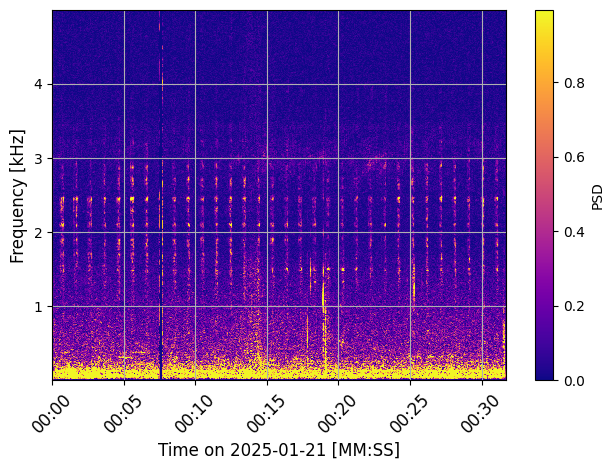

In [10]:
# Filters for frequency and time
time_filter = True
# time_filter = ((fft_datetimes > (video_start + datetime.timedelta(seconds=6*60+50)))
#                & (fft_datetimes <= (video_start + datetime.timedelta(seconds=7*60+0))) )
freq_filter = (fft_freqs > 0) & (fft_freqs <= 5000)

# Create figure
fig, ax = plt.subplots(1, 1)

# Plot the colormap
freq_plot = ax.pcolormesh(fft_datetimes[time_filter], fft_freqs[freq_filter]/1000,
                          Sx_psd[freq_filter, time_filter], cmap='plasma')

# Axis limits

# # For Evan Ludes 
# ax.set_ylim(0, 6)
# ax.set_xlim(datetime.datetime(2023, 11, 4, 12, 53, 50), datetime.datetime(2023, 11, 4, 12, 53, 55))
# # ax.set_xlim(datetime.datetime(2024, 11, 4, 12, 59, 15), datetime.datetime(2024, 11, 4, 12, 59, 30))

# # For Twitter
# ax.set_ylim(1, 4)
# ax.set_xlim(video_start + datetime.timedelta(seconds=20), video_end)

# # For Lach
# ax.set_ylim(0, 5)
# ax.set_xlim(video_start + datetime.timedelta(seconds=6*60+15), video_start + datetime.timedelta(seconds=6*60+30))

# Axis labels
ax.set_ylabel('Frequency [kHz]', fontsize=12)
ax.set_xlabel(f'Time on {video_start.date()} [MM:SS]', fontsize=12)
#ax.set_yscale('log')

# Make time look good
time_fmt = mdates.DateFormatter('%M:%S')
ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', which='major', labelsize=12,
               labelrotation=45)

plt.colorbar(freq_plot, ax=ax, label='PSD')
plt.grid()
#plt.axhline(3.750, color='red')

plt.tight_layout()

#plt.savefig('lach-spectragram-0-2hz-shortened-time.png', dpi=200)

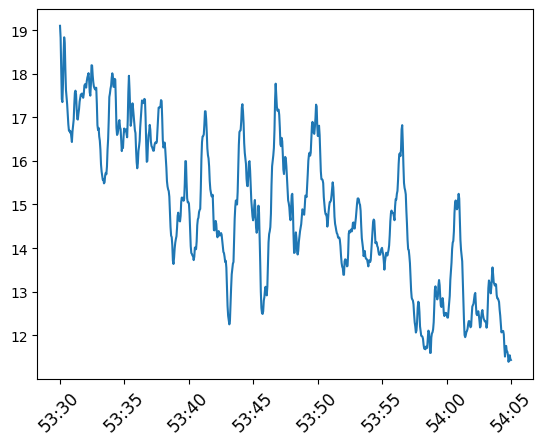

In [27]:
# Create a figure to show summed frequency with time

# Create a filter to only sum between certain frequencies and times
#freq_filter = (fft_freqs/1000 < 3.75) & (fft_freqs/1000 > 2.5)
freq_filter = (fft_freqs/1000 < 4.75) & (fft_freqs/1000 > 3.75)
time_filter = ((fft_datetimes > datetime.datetime(2023, 11, 4, 12, 53, 30)) 
                & (fft_datetimes < datetime.datetime(2023, 11, 4, 12, 54, 5)))

# Take a slice from the data and sum
psd_slice = np.sum(Sx_psd[freq_filter, :][:, time_filter], axis=0)

# Smooth the summed slice
N = 51
psd_smoothed = smooth(psd_slice, window_len=21, window='flat')

# Plot the figure
fig, ax = plt.subplots(1,1)
ax.plot(fft_datetimes[time_filter], psd_smoothed)

time_fmt = mdates.DateFormatter('%M:%S')
ax.xaxis.set_major_formatter(time_fmt)
ax.tick_params(axis='x', which='major', labelsize=12,
               labelrotation=45)

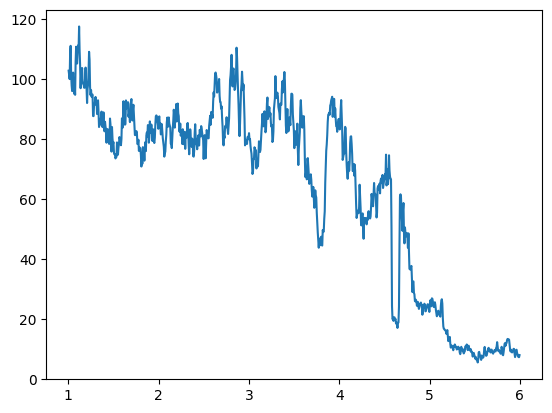

In [28]:
# Create a figure to show sum of time with frequency

freq_filter = (fft_freqs/1000 < 6) & (fft_freqs/1000 > 1)
time_filter = ((fft_datetimes > datetime.datetime(2023, 11, 4, 12, 53, 30)) 
                & (fft_datetimes < datetime.datetime(2023, 11, 4, 12, 54, 5)))

# Take a slice from the data and sum
psd_slice = np.sum(Sx_psd[freq_filter, :][:, time_filter], axis=1)

fig, ax = plt.subplots(1, 1)

ax.plot(fft_freqs[freq_filter]/1000, psd_slice)

## Code to read visual data from movie

In [9]:
def read_grayscale_frame(video, frame):
    """
    Function to read a frame from a opencv VideoCapture object
    INPUT
    vid_file
        type: OpenCV VideoCapture
        description: The object defining the video the frame is in
    frame
        type: int
        description: The frame number to get
    """
    # Read frame
    video.set(1, frame)
    ret, img = video.read()
    
    # Convert to grayscale assuming frames are in rgb
    gs_img = (img[:, :, 0]*0.2989 
              + img[:, :, 1]*0.5870 
              + img[:, :, 2]*0.1140)
    
    return gs_img

def average_frames(video, start_frame, length):
    """Function to average a number of frames together"""
    
    # Which frames to average
    frames = np.arange(0, length) + start_frame
    
    # Initialize array to sum all frames
    avg_img = read_grayscale_frame(video, start_frame)
    
    # Loop through and add frames to summed array
    for frame in frames[1:]:
        avg_img = avg_img + read_grayscale_frame(video, frame)
        
    # Get average by dividing by length
    avg_img = avg_img/length
    
    return avg_img

def process_img(frame):
    """Function to process image for animation"""
    
    # Only take every 5 frames as starting frame
    frame = frame + frame*4
    
    # Get the averaged image
    avg_img = average_frames(video, frame, 5)
    
    # Boost the contrast
    low = 0.1
    high = 99.8
    v_min, v_max = np.percentile(average_frames(video, 0, 5),
                                 (low, high))
    avg_img = exposure.rescale_intensity(avg_img, in_range=(v_min, v_max))
    
    return avg_img

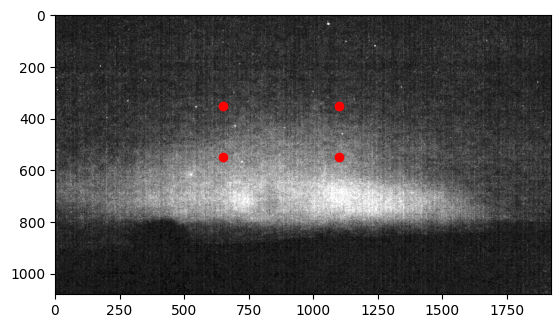

In [10]:
# Try averaging several frames
avg_img = average_frames(video, 0, 5)

# Try boosting contrast
low = 0.1
high = 99.8

v_min, v_max = np.percentile(avg_img, (low, high))

avg_contrast_img = exposure.rescale_intensity(avg_img, 
                                   in_range=(v_min, v_max))

plt.imshow(avg_contrast_img, cmap='gray')

plt.scatter(1100, 550, color='red')
plt.scatter(1100, 350, color='red')
plt.scatter(650, 550, color='red')
plt.scatter(650, 350, color='red')

In [11]:
# Plot average of pixel box for each frame
total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
avg_intensity = np.zeros(total_frames)
avg_intensity_2 = np.zeros(total_frames)

for frame in np.arange(0, total_frames):
    
    # Read in the image
    img = read_grayscale_frame(video, frame)
    
    # Get average for pixel box
    avg_intensity[frame] = np.mean(img)#np.mean(img[350:550, 650:1100])
    avg_intensity_2[frame] = np.mean(img[600:800, 900:1400])

    if frame%100 == 0:
        print(f'Finished {frame} of {total_frames}.')

Finished 0 of 1592.
Finished 100 of 1592.
Finished 200 of 1592.
Finished 300 of 1592.
Finished 400 of 1592.
Finished 500 of 1592.
Finished 600 of 1592.
Finished 700 of 1592.
Finished 800 of 1592.
Finished 900 of 1592.
Finished 1000 of 1592.
Finished 1100 of 1592.
Finished 1200 of 1592.
Finished 1300 of 1592.
Finished 1400 of 1592.
Finished 1500 of 1592.


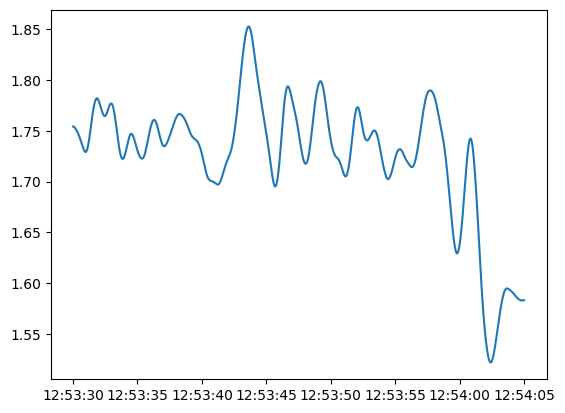

In [12]:
frame_time_filter = ((frame_timestamps > datetime.datetime(2023, 11, 4, 12, 53, 30)) 
                & (frame_timestamps < datetime.datetime(2023, 11, 4, 12, 54, 5)))
plt.plot(frame_timestamps[frame_time_filter], smooth(avg_intensity[frame_time_filter], window_len=51))
#plt.plot(frame_timestamps, smooth(avg_intensity_2, window_len=51))

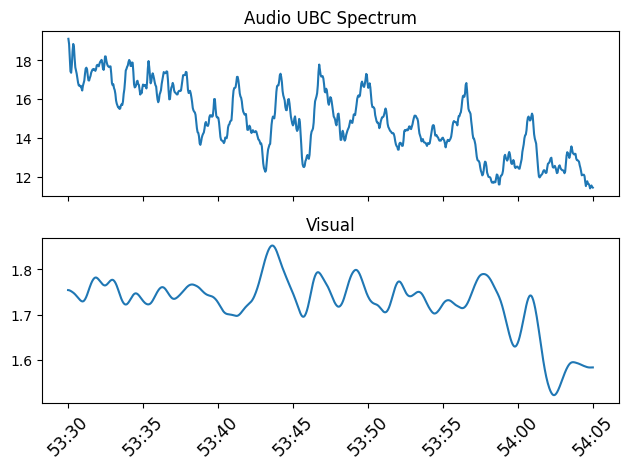

In [30]:
# Plot sound and frames side by side

fig, axs = plt.subplots(2,1, sharex=True)
axs[0].plot(fft_datetimes[time_filter], psd_smoothed)
axs[1].plot(frame_timestamps[frame_time_filter], smooth(avg_intensity[frame_time_filter], window_len=51))

time_fmt = mdates.DateFormatter('%M:%S')
# axs[0].xaxis.set_major_formatter(time_fmt)
# axs[0].tick_params(axis='x', which='major', labelsize=12,
#                labelrotation=45)
axs[0].set_title('Audio UBC Spectrum', fontsize=12)

axs[1].xaxis.set_major_formatter(time_fmt)
axs[1].tick_params(axis='x', which='major', labelsize=12,
               labelrotation=45)
axs[1].set_title('Visual', fontsize=12)

plt.tight_layout()

#plt.savefig('ludes-ubc-spectrogram-with-full-visual.png', dpi=200)

## Old Code below

In [236]:
# Create FFT for specified capture
start_time = 0
waveform = audio_array

# Create indices to create ffts for
fft_window = int(1024*4)

# Indices
indices = np.arange(0, len(waveform), 1)

# Window step
step = int(fft_window/2)

# Remove step length from end of indices
indices = indices[0:-fft_window]

# Loop through every step amount
indices = indices[0::step]

# Create array to store FFT
psd = np.zeros([fft_window, len(indices)])
for n, i in enumerate(indices):
    # Perform the fft
    data = waveform[i : i+fft_window]
    fft = np.fft.fft(data)
    #...then write to array and get psd
    psd[:, n] = np.abs(fft)**2
    
# Filter to psd range
psd_min = 1e-2
psd_max = 1e-1
psd[psd < psd_min] = psd_min
psd[psd > psd_max] = psd_max

# Create meshgrids for time and frequency
#...time coverage is 6 seconds
#...to make range first convert to timestamp
burst_times = np.linspace(0, total_time, len(indices))
tstep = total_time/len(indices)

# Frequency
burst_freq = np.linspace(0, fft_window, fft_window)/tstep

# Turn into meshgrids
burst_time_mesh, burst_freq_mesh = np.meshgrid(burst_times,
                                               burst_freq)

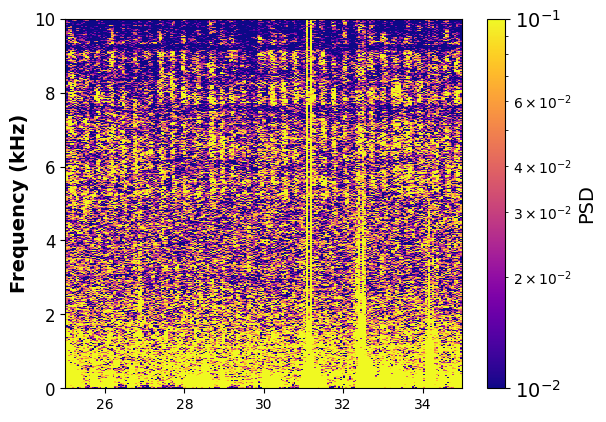

In [237]:
# Plot the psd spectrum
fig, ax = plt.subplots()
psd_plot = ax.pcolormesh(burst_time_mesh, burst_freq_mesh/1000,
                         psd,
                         norm=mcolors.LogNorm(),
                         cmap='plasma', shading='auto')

# Create colorbar
psd_cbar = fig.colorbar(psd_plot, ax=ax)
psd_cbar.set_label(r'PSD', fontsize=14)
psd_cbar.ax.tick_params(labelsize=14)

# Setup axes
ax.set_ylabel('Frequency (kHz)', fontsize=14, fontweight='bold')

#ax.set_xlim(start_time, end_time)
ax.set_ylim(0, 10)
#ax.set_yscale('log')
ax.set_xlim(25, 35)


ax.tick_params(axis='y', which='major', labelsize=12)

In [51]:
# Get the slice of data corresponding to frequencies
psd_slice = psd[(burst_freq >= 5000) & (burst_freq<=9000),
                  :]

# Average over frequencies
psd_slice = np.mean(psd_slice, axis=0)

# Any signal > specified value is set to average of values around it
spikes = np.where(psd_slice > 0.075)[0]

no_spikes = np.where(psd_slice <= 0.075)[0]

# Loop through each spike
for spike in spikes:
    
    # Find the 5 closest values
    diff = abs(no_spikes - spike)
    avg_points = no_spikes[np.argpartition(diff, 5)[0:5]]
    
    psd_slice[spike] = np.mean(psd_slice[avg_points])

# Calculate the rolling average of the event
N = 51
psd_smoothed = np.convolve(psd_slice, np.ones((N,)) / N,
                                   mode='valid')

psd_x_smoothed = burst_times[math.floor(N / 2):-math.floor(N / 2)]

# Exclude start and end times
psd_smoothed = psd_smoothed[(psd_x_smoothed > 12) 
                            & (psd_x_smoothed < 50)]
psd_x_smoothed = psd_x_smoothed[(psd_x_smoothed > 12) 
                                & (psd_x_smoothed < 50)]

# # Shift so average is zero
# psd_smoothed = (psd_smoothed - np.mean(psd_smoothed))

# # Normalize psd so max is also 1
# psd_smoothed = psd_smoothed/np.max(psd_smoothed)

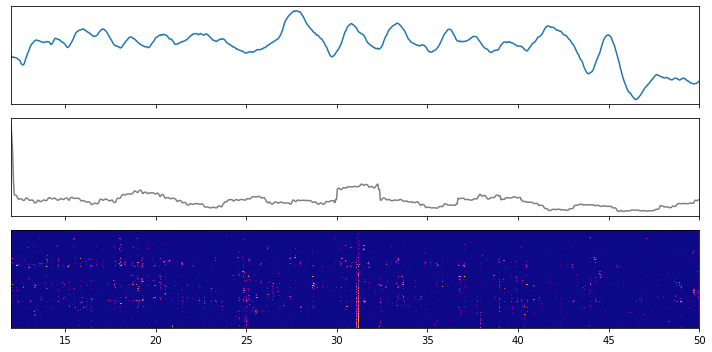

In [52]:
fig, axs = plt.subplots(3, 1, sharex=True,
                        figsize=(10,5))

# Plot average along with audio psd
audio_x = psd_x_smoothed
video_x = np.linspace(0, total_time, len(avg_intensity_smoothed))

axs[0].plot(video_x, avg_intensity_smoothed, color='C0')
axs[1].plot(audio_x, psd_smoothed, color='gray')

axs[1].vlines(burst_times[spikes], np.min(psd_smoothed),
           np.max(psd_smoothed), color='red')

axs[2].pcolormesh(burst_time_mesh, burst_freq_mesh/1000,
                         psd,
                         norm=mcolors.LogNorm(),
                         cmap='plasma', shading='auto')

# Setup axes
axs[2].set_ylabel('kHz')

#ax.set_xlim(start_time, end_time)
axs[2].set_ylim(4, 10)

# Turn off y axis
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)
axs[2].yaxis.set_visible(False)

plt.xlim(12, 50)
#plt.ylim(-0.5, 1.25)

plt.tight_layout()

plt.savefig('../possible-correlation.jpg', dpi=200)